# COMP90051 Project 2

In [103]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implementing ε-Greedy and UCB

In [104]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [105]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        
        # Validation Inputs... 
        
        assert narms > 0, "Arms should be greater than zero..."        
        
        self.narms = [Q0] * narms
        self.epsilon = epsilon 
        self.arm_count = [0] * narms  # array that will my arm counter

        
    def play(self, tround, context=None):
        if np.random.random() > self.epsilon:       
            largest_value = max(self.narms)     # getting arm with largest value
            indices = [idx for idx, val in enumerate(self.narms) if val == largest_value]
            return np.random.choice(indices)

        else:
            return np.random.randint(0,len(self.narms) - 1)
        
        
    def update(self, arm, reward, context=None):
        # Increment selected arm count by one in arm counter
        self.arm_count[arm] += 1
        arm_value = self.arm_count[arm]

        # Re calculate the estimated value of selected arm using given reward
        value = self.narms[arm]
        updated_value = value * ((arm_value - 1) / arm_value) + reward / arm_value
        updated_value = np.nan_to_num(updated_value)   # handling NAN values 
        self.narms[arm] = updated_value
         


In [106]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        
        # Validation Inputs... 
        
        assert narms > 0, "Arms should be greater than zero..."        
        
        self.narms = [Q0] * narms   # estimated value tracker  2 
        self.rho = rho 
        self.arm_count = [0] * narms # round tracker 0
        self.reward = [0] * narms  # reward tracker 1

    def play(self, tround, context=None):
        
        total_arms = len(self.arm_count)
        arm_id = 0
        for arm in range(0, total_arms):
            Nt = self.arm_count[arm]
            if (Nt == 0):
                value = self.narms[arm]
            else:
                # 2  Calculate Mean
                mean = (self.reward[arm]) / float(Nt)
                # 3  calculate estimated reward 
                self.narms[arm] = mean + np.sqrt((self.rho * np.log(tround)) / float(Nt))  
        
        # Select arm with highgest maximum estimated values 
        largest = max(self.narms)
        
        # Check for multiple maximum values and then use random tie breaker....
        #if it is a tie, choose randonly any one of the arm
        
        indices = [idx for idx, val in enumerate(self.narms) if val == largest]
        return np.random.choice(indices)

    
    def update(self, arm, reward, context=None):
        
        self.arm_count[arm] = self.arm_count[arm] + 1    # update arm counter 
        count = self.arm_count[arm]
        value = self.narms[arm]        
        self.reward[arm] += reward                      # update reward

## 2. The Basic Thompson Bandit

In [107]:
class BetaThompson(MAB):
    """
    Beta-Bernoulli Thompson sampling multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    alpha0 : float, optional
        positive real prior hyperparameter

    beta0 : float, optional
        positive real prior hyperparameter
    """
    
    def __init__(self, narms, alpha0=1.0, beta0=1.0):
        
         # Validation Inputs...  
        assert narms > 0, "Arms should be greater than zero..."   
        
        self.narms = [0] * narms
        self.success = [0] * narms
        self.failure = [0] * narms
        self.total_reward = 0
        self.alpha0 = alpha0
        self.beta0 = beta0
        
    
    def play(self, tround, context=None):
        arm_id = 0
        max_random = 0
        total_arms = len(self.narms)
        for arm in range(total_arms):
            random_beta = np.random.beta(self.success[arm] + self.alpha0, self.failure[arm] + self.beta0)  #Random beta sample
            if random_beta > max_random:                            
                max_random = random_beta
                arm_id = arm
        return arm_id
        
    def update(self, arm, reward, context=None):
         if reward == 1:
            self.success[arm] = self.success[arm] + 1  #update success
         else:
            self.failure[arm] = self.failure[arm] + 1  #update fail
         self.total_reward =  self.total_reward + reward   #update reward

## 3. Off-Policy Evaluation

In [108]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    
    prev = []
    payOff = []
    Trounds = 1
    event = 0 
    while ((Trounds < nrounds) & (event < arms.__len__())):
        

        if (int(mab.play(Trounds, contexts[event])) == ((int(arms[event]))-1)): 

            mab.update((int(arms[event])) - 1  , int(rewards[event]), contexts[event]) 
            payOff.append(int(rewards[event]))
            Trounds = Trounds + 1  

        event = event + 1

    return payOff



In [109]:
#Reading Input File dataset.exe

arms = []
rewards = []
contexts = []
i = 0
for line in open("dataset.txt"):  
    listWords = line.rstrip().split(" ") 
    arms.append(listWords[0])  
    rewards.append(listWords[1]) 
    contexts.append(listWords[2:])  


arms = np.array(arms)  
rewards = np.array(rewards) 
contexts = np.reshape(np.array(contexts), (10000, 100))  

In [112]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.26533166458072593


In [115]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.16020025031289112


In [146]:
mab = BetaThompson(10, 1.0, 1.0)
results_BetaThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
check = np.mean(results_BetaThompson)

        

BetaThompson average reward 0.2528160200250313


## 4. Contextual Bandits - LinUCB

In [147]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        
         # Validation Inputs...  
        assert narms > 0, "Arms should be greater than zero..."
        assert ndims > 0, "dimension should be greater than zero..."
        
        
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha

        ''' Variable description...  
            Name are set to be A and B as decsribed in the given algorithm...
            1. A - Feture matrix
            2. B - vector to store returns for each arm
            3. payOff - Estimated payoff value 
        '''
        
        self.A = []
        for a in range(0, self.narms):
            self.A.append(np.identity(self.narms))
        self.B = []
        for a in range(0, self.narms):
            self.B.append([0.0] * self.narms)  

        self.payOff = [np.inf] * self.narms
        
        
    def play(self, tround, context):
        theta = None
        arms = 0
        arm_id = 0
        total_arms = len(self.payOff)
        self.context = np.reshape(context.astype(np.float), (10, 10))
        
        for arm in range(total_arms):
            theta = np.matmul(np.linalg.inv(self.A[arm]), self.B[arm])
            
            x = np.matmul(self.context[arm].transpose(), np.linalg.inv(self.A[arm]))

            self.payOff[arm] = np.matmul(theta.transpose(), self.context[arm]) + (
                        np.dot(self.alpha , np.sqrt(np.matmul(x, self.context[arm]))))

            # choose the max best arm and handle tie breaker...
        largest = max(self.payOff)
        indices = [idx for idx, val in enumerate(self.payOff) if val == largest]
        #print(indices)
        return np.random.choice(indices)
        
        # if it is a tie, choose randonly any one of the arm


    
    def update(self, arm, reward, context):
        context = np.reshape(context.astype(np.float), (10, 10))

        # Update A (Feature Matrix)
        self.A[arm] = np.add(self.A[arm],
                                    np.matmul(context[arm].astype(np.float), context[arm].astype(np.float).transpose()))

        # update B (vector of arm return)
        self.B[arm]= np.add(self.B[arm], (np.dot(reward, np.array(context[arm].astype(np.float)))))


In [148]:
mab = LinUCB(10, 10, 0.001)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.2690863579474343


## 5. Contextual Bandits - LinThompson

In [149]:
class LinThompson(MAB):
    """
    Contextual Thompson sampled multi-armed bandit (LinThompson)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    v : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, v):
        
         # Validation Inputs...  
        assert narms > 0, "Arms should be greater than zero..."
        assert ndims > 0, "dimension should be greater than zero..."
        
        self.narms = narms
        self.ndims = ndims
        self.v = v

        '''create a matrix to store 
         Name are set to be A and B as decsribed in the given algorithm...
            1. B - Feature matrix 
            2. Mean - cvector to store mean value
            3. p - Estimated payoff value 
        '''       
        self.B = np.identity(self.narms)
        self.Mean = [0] * self.narms         
        self.F = [0] * self.narms
       
    def play(self, tround, context):
        
        v = self.v**2
        context = np.reshape(context.astype(np.float), (10, 10)) 
        covariance = np.dot(np.linalg.inv(self.B) , v)            
        random_normal = np.random.multivariate_normal(self.Mean  , covariance)
        reward= np.matmul(context,random_normal)
        largest = max(reward)
        indices = [idx for idx, val in enumerate(reward) if val == largest]
        return np.random.choice(indices)
  
    def update(self, arm, reward, context):

        context = np.reshape(context.astype(np.float), (10, 10))   
        self.B = np.add(self.B, np.matmul(context[arm].astype(np.float), context[arm].astype(np.float).transpose()))        
        self.F = np.add(self.F, (np.dot( np.array(context[arm].astype(np.float)) , reward))  )      
        self.Mean = np.matmul(np.linalg.inv(self.B), self.F)


In [150]:
mab = LinThompson(10, 10, 1.0)
results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
#print(results_LinThompson)
print("LinThompson average reward ", np.mean(results_LinThompson))


LinThompson average reward  0.3341677096370463


## 6. Evaluation
### 6.A.

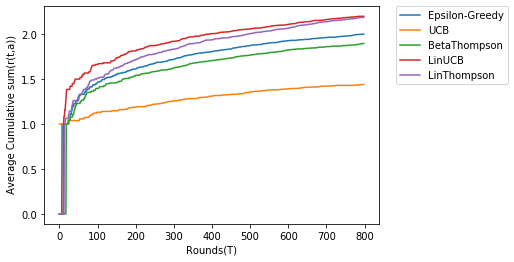

In [151]:
# Average cumalative sum per round ....    T(inverse) Sigma(t=0, t = T) for T = 1..800

def averageCumSum(result):
        cumsum = [0] * len(result)
        prev_val = 0
        for index,value in enumerate(result): 
            if (value != 0 and  prev_val !=0 ):
                sum = (prev_val) + (value/index)
            else:
                sum = (prev_val) + value            
            cumsum[index] = sum
            prev_val = sum
        
        return cumsum
    
plt.plot(averageCumSum(results_EpsGreedy) , label = "Epsilon-Greedy")
plt.plot(averageCumSum(results_UCB), label = "UCB")
plt.plot(averageCumSum(results_BetaThompson) , label = "BetaThompson")
plt.plot(averageCumSum(results_LinUCB), label = "LinUCB")
plt.plot(averageCumSum(results_LinThompson), label = "LinThompson")
plt.ylabel(' Average Cumulative sum(r(t,a))')
plt.xlabel('Rounds(T)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()



### 6.B.

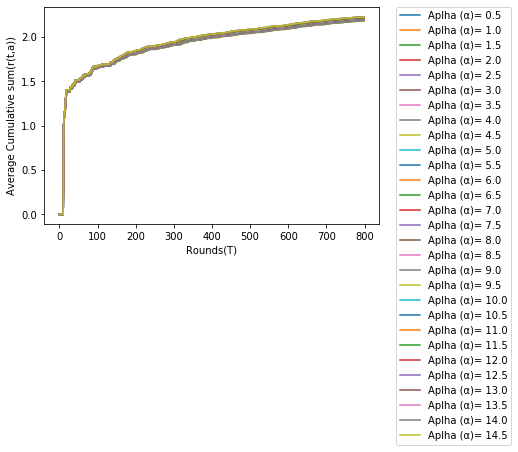

In [157]:
# Grid Search .... hyper-parameter tuning...For linUcb

count = 0
results =[]
for x in np.arange(0.5, 15, 0.5):
    mab = LinUCB(10, 10, x )
    results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)  
    plt.plot(averageCumSum(results_LinUCB) , label = "Aplha (α)= "+str(x))
    results.append([np.mean(results_LinUCB),x])
    count = count + 1

plt.ylabel('Average Cumulative sum(r(t,a))')
plt.xlabel('Rounds(T)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [158]:
print("Mean values  for Alpha values")
print(results)

maxValue = 0 
parameter = 0
for value in results:
    if maxValue < value[0]:
        maxValue = value[0]
        parameter =value[1]
        
print("Maximum Value for Alpha")
print("\n")
print ( "Max mean =", maxValue )
print("\n")
print ( " Aplha =", parameter )



Mean values  for Alpha values
[[0.27033792240300375, 0.5], [0.26783479349186484, 1.0], [0.26783479349186484, 1.5], [0.26783479349186484, 2.0], [0.26783479349186484, 2.5], [0.26783479349186484, 3.0], [0.26783479349186484, 3.5], [0.26783479349186484, 4.0], [0.26783479349186484, 4.5], [0.26783479349186484, 5.0], [0.2690863579474343, 5.5], [0.2690863579474343, 6.0], [0.27033792240300375, 6.5], [0.27033792240300375, 7.0], [0.27033792240300375, 7.5], [0.2690863579474343, 8.0], [0.27033792240300375, 8.5], [0.2690863579474343, 9.0], [0.2690863579474343, 9.5], [0.2690863579474343, 10.0], [0.27033792240300375, 10.5], [0.2690863579474343, 11.0], [0.2690863579474343, 11.5], [0.2715894868585732, 12.0], [0.2715894868585732, 12.5], [0.2715894868585732, 13.0], [0.27284105131414266, 13.5], [0.27284105131414266, 14.0], [0.27284105131414266, 14.5]]
Maximum Value for Alpha


Max mean = 0.27284105131414266


 Aplha = 13.5


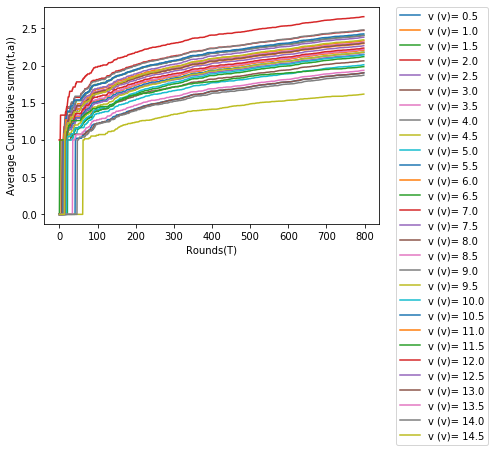

In [155]:
# Grid Search .... hyper-parameter tuning...For linUcb

count = 0
for x in np.arange(0.5, 15, 0.5):
    mab = LinThompson(10, 10, x)
    results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)  
    plt.plot(averageCumSum(results_LinThompson) , label = "v (v)= "+str(x))
    results.append([np.mean(results_LinThompson),x])
    count = count + 1

plt.ylabel('Average Cumulative sum(r(t,a))')
plt.xlabel('Rounds(T)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [156]:
print("Mean value with for (v) values")
print(results)

maxValue = 0 
parameter = 0
for value in results:
    if maxValue < value[0]:
        maxValue = value[0]
        parameter =value[1]
        
print("Maximum Value for (v)")
print("\n")
print ( "Max mean =", maxValue )
print("\n")
print ( " v =", parameter )



Mean value with for (v) values
[[0.27033792240300375, 0.5], [0.26783479349186484, 1.0], [0.26783479349186484, 1.5], [0.26783479349186484, 2.0], [0.26783479349186484, 2.5], [0.26783479349186484, 3.0], [0.26783479349186484, 3.5], [0.26783479349186484, 4.0], [0.26783479349186484, 4.5], [0.26783479349186484, 5.0], [0.344180225281602, 0.5], [0.3354192740926158, 1.0], [0.35168961201501875, 1.5], [0.35544430538172717, 2.0], [0.3316645807259074, 2.5], [0.3504380475594493, 3.0], [0.3429286608260325, 3.5], [0.32916145181476847, 4.0], [0.32916145181476847, 4.5], [0.3316645807259074, 5.0], [0.32916145181476847, 0.5], [0.33291614518147683, 1.0], [0.3354192740926158, 1.5], [0.3341677096370463, 2.0], [0.3316645807259074, 2.5], [0.3316645807259074, 3.0], [0.3316645807259074, 3.5], [0.3341677096370463, 4.0], [0.2503128911138924, 4.5], [0.32916145181476847, 5.0], [0.3316645807259074, 5.5], [0.3341677096370463, 6.0], [0.35294117647058826, 6.5], [0.3316645807259074, 7.0], [0.3304130162703379, 7.5], [0.329